In [2]:
# Importing necessary libraries and packages
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Dataset Preprocessing

In [3]:
# Importing training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Importing validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [6]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation")

There are 500 images of horses for training
There are 527 images of humans for training
There are 128 images of horses for validation
There are 128 images of humans for validation


Sample horse image:


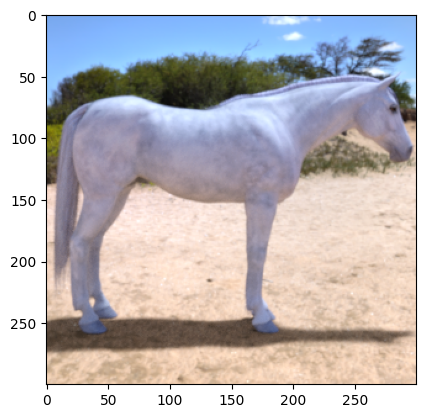


Sample human image:


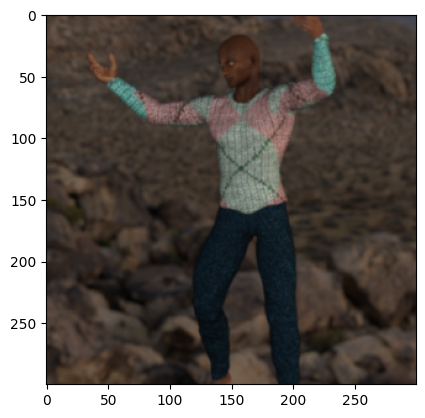

In [7]:
# Taking a look at a sample image
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

these images have a resolution of 300x300 and are colored:

In [8]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


# Training and Validation Generators

In [9]:
# This function will feed those images to the network
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """

  # Generator for training dataset
  train_datagen = ImageDataGenerator(rescale = 1./255.)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150)) # yielding much quicker training times without compromising the accuracy

  # Generator for validation dataset
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Transfer learning

In [11]:
# Download the inception v3 weights into the /tmp/ directory
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-02-21 05:01:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   203MB/s    in 0.4s    

2024-02-21 05:01:37 (203 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [12]:
# Import the InceptionV3 model and save the path to the weights
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [13]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

Check if everything went well by comparing the last few rows of the model summary to the expected output:

In [14]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [15]:
# Checking if all the layers in the model were set to be non-trainable
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


# Callbacks

the callback will stop training once an accuracy of 99.9% is reached

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

# Pipelining the pre-trained model

Now that the pre-trained model is ready, it will be "glued" it to my own model to solve the task.

the last output of the pre-trained model will be needed, since this will be the input for my network.

In [17]:
last_desired_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_desired_layer.output_shape)
last_output = last_desired_layer.output
print('last layer output: ', last_output)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [19]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


To finish the final model, some additional layers on top of the pre-trained model will be created. To do this, I'm using Keras' model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [20]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=pre_trained_model.input, outputs=x) # Create the complete model by using the Model class

  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [21]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


It is surely a lot of parameters, eventhough I already change the images dimension into 150x150

# Training the Model

In [22]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 18s - loss: 0.0442 - accuracy: 0.9786 - val_loss: 0.0378 - val_accuracy: 0.9805 - 18s/epoch - 531ms/step
Epoch 2/100

Reached 99.9% accuracy so cancelling training!
33/33 - 7s - loss: 6.4640e-04 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9844 - 7s/epoch - 201ms/step


The training stopped after less than 10 epochs and it has reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model I used, which already contained information to classify humans from horses.

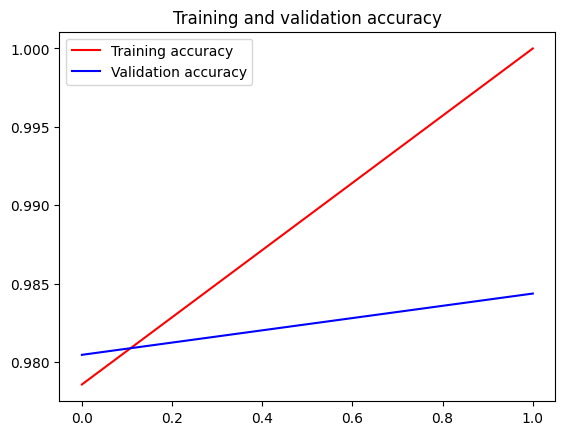

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Both training and validation accuracy steadily increase with each epoch, indicating effective learning without significant overfitting or underfitting.

# Testing

1/1 [==============================] - 0s 115ms/step


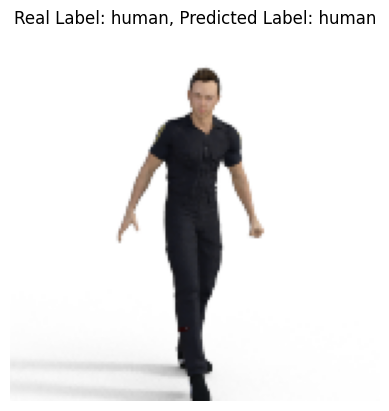

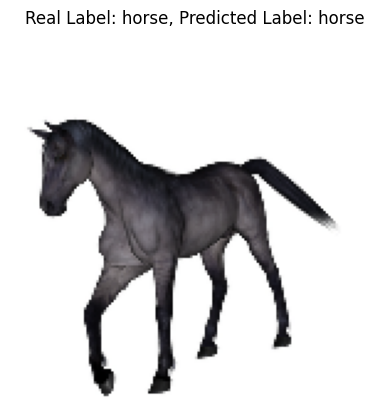

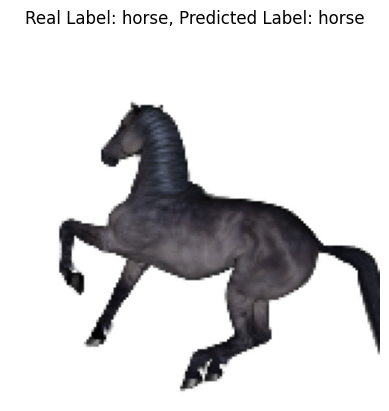

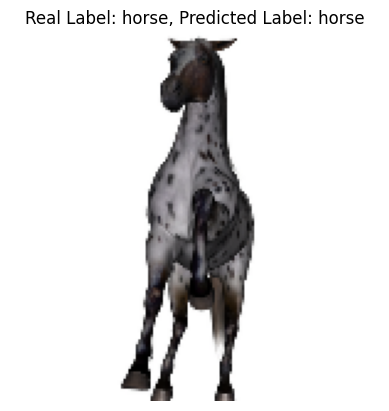

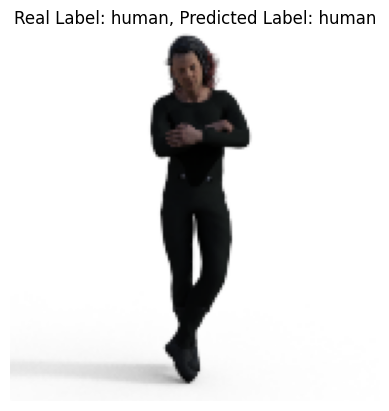

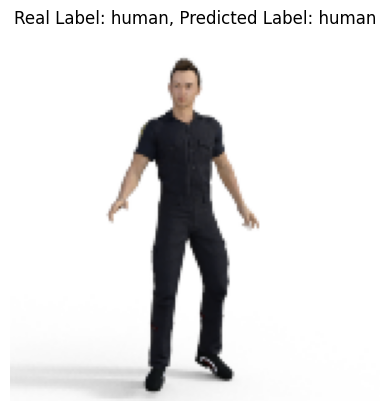

In [36]:
# Define labels
labels = {0: 'horse', 1: 'human'}

# Predict and print results for correctly predicted samples
correct_counts = {'horse': 0, 'human': 0}

for batch_images, batch_labels in validation_generator:
    predictions = model.predict(batch_images)
    predicted_labels = np.round(predictions).flatten().astype(int)

    for img, true_label, predicted_label in zip(batch_images, batch_labels, predicted_labels):
        true_label = labels[int(true_label)]
        predicted_label = labels[predicted_label]

        if true_label == predicted_label and correct_counts[true_label] < 3:
            plt.imshow(img)
            plt.title(f'Real Label: {true_label}, Predicted Label: {predicted_label}')
            plt.axis('off')
            plt.show()
            correct_counts[true_label] += 1

        if all(count == 3 for count in correct_counts.values()):
            break

    if all(count == 3 for count in correct_counts.values()):
        break
